<a href="https://colab.research.google.com/github/Sonchecho/DataScience300/blob/main/Proyecto_final_PrecioInomobiliario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimación del precio de un Inmueble

Una innombiliaria desea un modelo predictivo el cual sea capaz de estimar el precio de una casa a traves de ciertas variables de entrada. No obstante, tambien desea realizar una segmentación sobre los datos que se tiene para poder saber si puede realizar una diferenciación entre grupos de casas, de tal manera que con esta información pueda ver que tipos de casa pueden ser ofrecidas segun el tipo de cleinte que se tenga.

**Librerias**

In [ ]:
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from scipy.stats import pearsonr 
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, max_error, mean_absolute_error, median_absolute_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import plot_tree

**Funciones**

In [ ]:
def Euclidea(media,x): 
    n = len(media)
    suma = 0
    for i in range(n):
        suma = suma + (media[i]-x[i])**2
    return np.sqrt(suma)

def Mahalanobis(media,x,covarianza):
    inversa_covarianza = np.linalg.inv(covarianza)
    n,m  = np.shape(covarianza)
    aux = np.reshape((media.T - x.T),(1,n))
    distancia  = np.dot(np.dot(aux,inversa_covarianza),aux.T)
    return np.double(np.sqrt(distancia))

def Limpieza(x,nombre):
    media = np.mean(x,axis=0)
    distancias = []
    instancia, varaibles = np.shape(x)
    covarianza = np.cov(x.T)
    for i in range(instancia):
        if (nombre == "Euclidea"):
            distancia = Euclidea(media,x[i,:])
        else:
            distancia = Mahalanobis(media,x[i,:],covarianza)
        distancias.append(distancia)
    percentil = np.percentile(distancia,99)
    indices = np.where(distancias <= percentil)
    x_clean = np.delete(x,indices,0)
    return x_clean

def Lasso (data,label):

    parameter = np.arange(1,10,0.1)
    funciones_objetivo = []
    lista_variables  = []

    for c in parameter:
        clf = linear_model.Lasso(max_iter=10000000, alpha = c)
        clf.fit(data,label)
        coeficiente = np.array(clf.coef_)
        pesos_elimar = np.where(coeficiente[0] == 0)
        prediction = clf.predict(data)
        accuracy = mean_squared_error(label,prediction) #Funcion objetivo 
        funciones_objetivo.append(accuracy)
        lista_variables.append(pesos_elimar)

    maximo = np.argmax(funciones_objetivo)
    parametro_optimo = parameter[maximo]
    variables_eliminar = lista_variables[maximo]

    return parametro_optimo, variables_eliminar[0]

def compute_metrics(y_val, y_pred):
    metrics = {}
    metrics['mean_squared_error'] = mean_squared_error(y_pred,y_val)
    metrics['max_error'] = max_error(y_pred,y_val)
    metrics['mean_absolute_error'] = mean_absolute_error(y_pred,y_val)
    metrics['median_absolute_error'] = median_absolute_error(y_pred,y_val)
    metrics['r2_score'] = r2_score(y_pred,y_val)
    return metrics

def assess_performance(classifiers, X_eval, y_eval):
    performance = {}
    for index, classifier in enumerate(classifiers):
        y_pred = classifier.predict(X_eval)
        performance['C{}'.format(index + 1)] = compute_metrics(y_eval, y_pred)
    return performance


**Importar datos**

In [ ]:
data = pd.read_csv('data.csv')
price = data['price']
input_data = data.drop(['date','price','street','statezip','country','yr_renovated'], axis=1)
variables = input_data.columns

Tenemos que las variables de entrada que se van a utilizar para poder estimar el precio de la casa son las siguientes con su clasificiación

1. Numero de baños (Discreta)
2. Numero de habitaciones (Discreta)
3. Tamaño de la sala (Continua)
4. Tamaño del lote (Continua)
5. Numero de pisos (Discreta)
6. Si esta frente al mar (Binaria)
7. Vista (calificada de 0 a 4) (Discreta)
8. Condiciones de vivienda (calificada de 0 a 5) (Discreta)
9. Tamaño de la terraza (Continua)
10. Tamño del Sotano (Continua)
12. Años de construida (Discreta)
13. Ciudad (Ordinal)

Ahora procedemos a relizar la codificación de las variables categoricas 

In [ ]:
numerical_data = input_data.drop('city', axis =1)
categorial_cada = input_data['city']
ct = LabelEncoder()
categorial_cada = ct.fit_transform(categorial_cada)
categorial_cada = categorial_cada.reshape(len(categorial_cada),1)
data = np.concatenate((numerical_data,categorial_cada), axis =1)

# Analisis Descriptivo variables de entrada

1. Mostramos un analisis descriptivo de las variables de entrada en donde se puede ver el número de datos, la media, la desviación y los cuartiles

In [ ]:
DataFrame_Input = pd.DataFrame(data,columns = variables )
DataFrame_Input.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,city
count,4600.000000,4600.000000,4600.000000,4.600000e+03,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000
mean,3.400870,2.160815,2139.346957,1.485252e+04,1.512065,0.007174,0.240652,3.451739,1827.265435,312.081522,1970.786304,25.674348
std,0.908848,0.783781,963.206916,3.588444e+04,0.538288,0.084404,0.778405,0.677230,862.168977,464.137228,29.731848,11.982721
min,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000
25%,3.000000,1.750000,1460.000000,5.000750e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,17.000000
50%,3.000000,2.250000,1980.000000,7.683000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,32.000000
75%,4.000000,2.500000,2620.000000,1.100125e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,610.000000,1997.000000,35.000000
max,9.000000,8.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,43.000000


2. Ahora Mostramos la distribución que tiene cada una der las variables , para ver si alguna de ella tiene sesgos en la información que nos da

<Figure size 432x288 with 0 Axes>

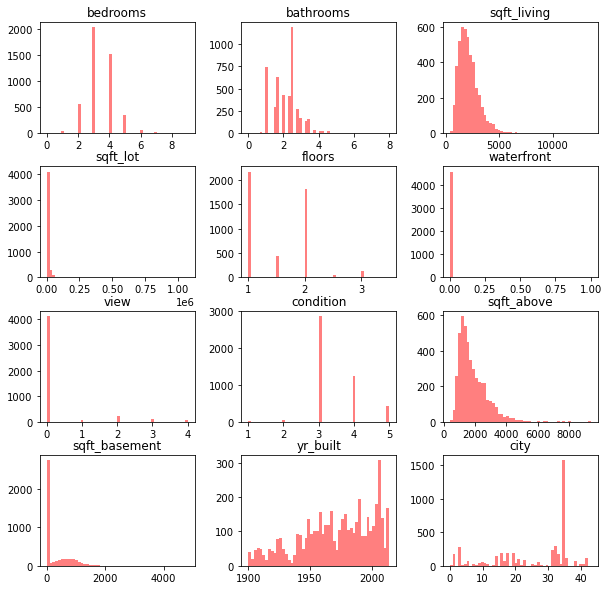

In [ ]:
plt.figure()
hist = DataFrame_Input.hist(color="r", alpha=0.5, bins=50,figsize=(10, 10), grid = False)

Podemos ver que existen sesgo con respecto a algunas variables, tale como: 

1. Tamaño de la sala: La mayoria de los inmubeles que tienen un tamaño de sala puequeño.
2. Tamaño de la terrasa: Hay pocos inmubeles que tenga tamaño de terraza mayor a 5000 $ft^2
3. Años de construcción: Hay una mayor cantidad de casas construidad despues de 1950, que antes de este año
4. Cidudad: Se tiene más datos de inmubeles en una ciudad especifica 


Estos sesgos de una u otra manera puedena afectar el desempeño de generaliazión del modelo que se escoga, debido a que si el modelo recibe datos de un inmueble con un tamaño de sala grande, con terrasa mayor a 5000 ft^2, y construida antes de 1950, entonces dicho modelo no va a tener una buena capacidad para predicir el precio. 

3. Ahora procedemos a mostrar los diagramas de cajas para cada una de las variables de tal manera que podamos ver si hay datos atipicos 


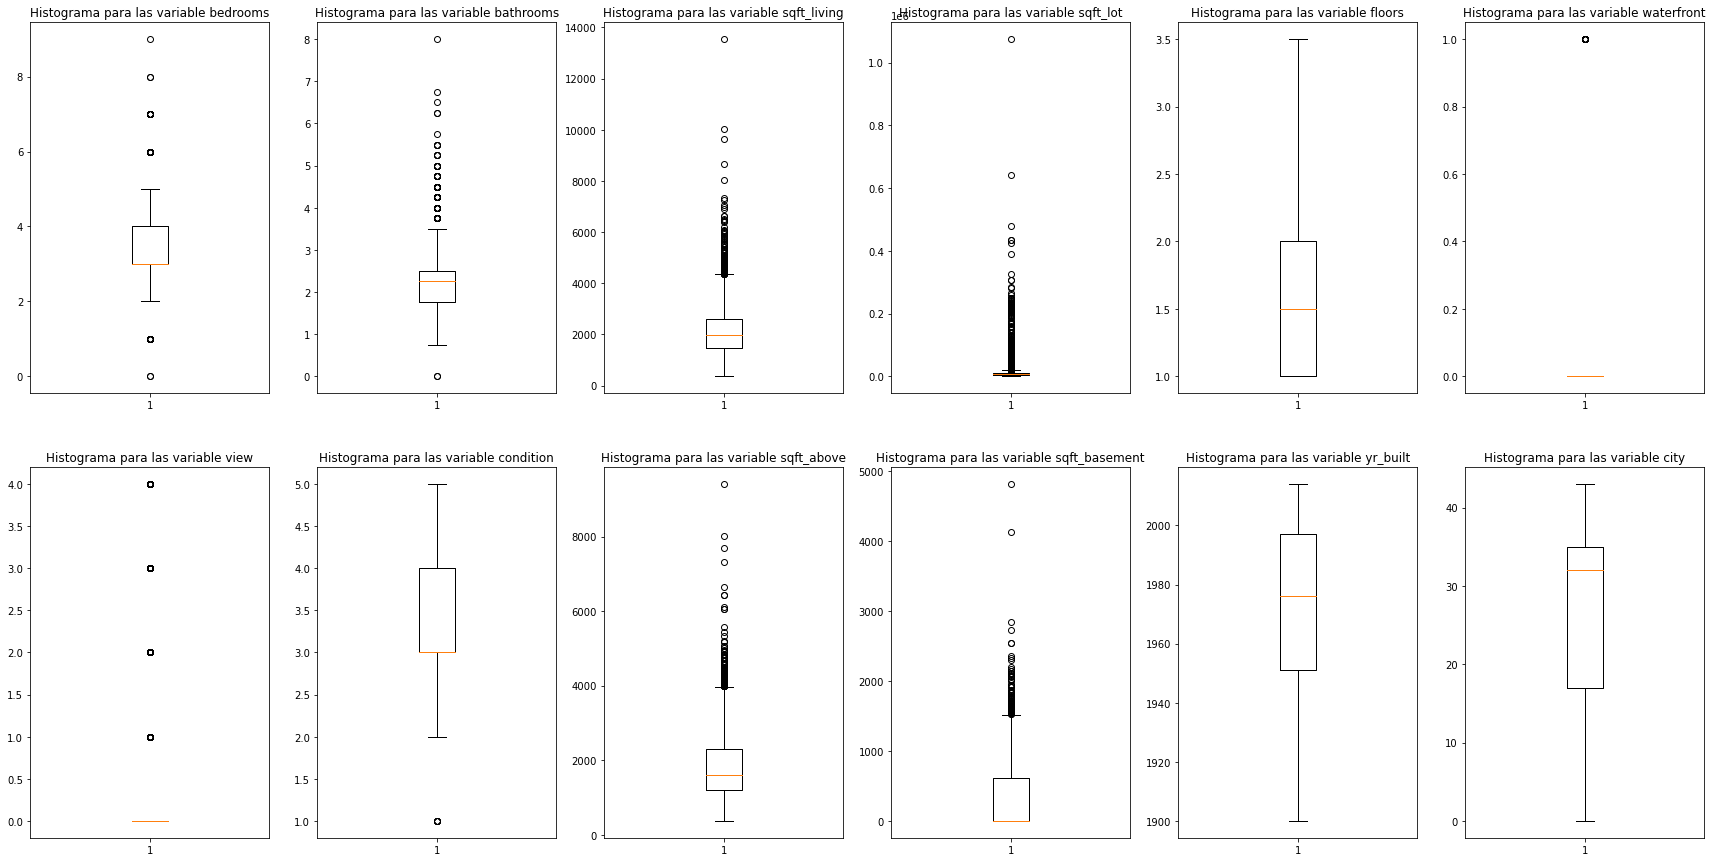

In [ ]:
color = {"boxes": "Red",
"whiskers": "Orange",
"medians": "Blue",
"caps": "Gray"}

fig, axs = plt.subplots(2,6, figsize=(30,15))
indice = range(0,12,1)

for i,variable in zip(indice, variables):
    axs[int(i/6),i%6].boxplot(DataFrame_Input[variable])
    axs[int(i/6),i%6].set_title('Histograma para las variable ' + variable)


Tenemos entonces que hay variables que tiene datos atipicos, tal como el tamaño de la sala, el tamño del lote, el tamaño de la terraza, el de sotano, las cuales coinciden con alguas de las variables sesgadas que encontramos en el item anterior

# Analísis Descriptivo variable de Salida

A continuación mostramos el histograma, el diagrama de cajas y la estadistica descriptiva de la variable de salida

In [ ]:
Price_DataFrame = pd.DataFrame(price, columns = ['price'])

Price_DataFrame.describe()

,price
count,4.600000e+03
mean,5.519630e+05
std,5.638347e+05
min,0.000000e+00
25%,3.228750e+05
50%,4.609435e+05
75%,6.549625e+05
max,2.659000e+07


array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

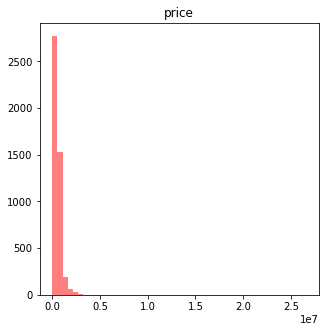

In [ ]:
Price_DataFrame.hist(color="r", alpha=0.5, bins=50,figsize=(5, 5), grid = False)

<AxesSubplot:>

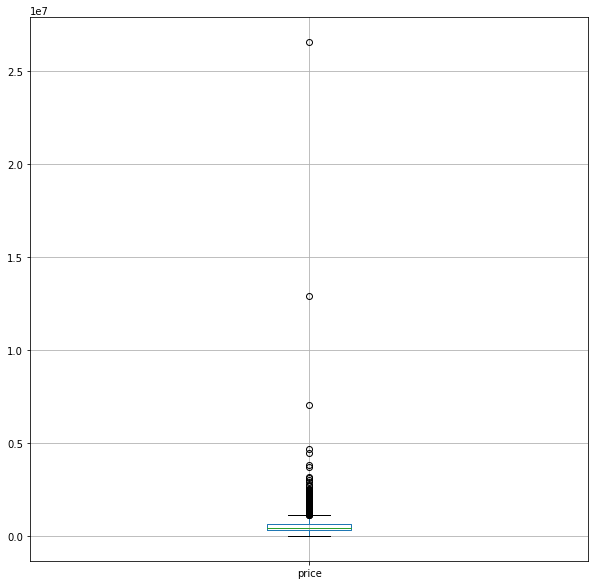

In [ ]:
Price_DataFrame.boxplot(figsize=(10, 10))

 Tenemos que el precio de igual manera esta sesgado hacia precios mucho menores, por lo que el modelo no tenfra un buen desempeño en cuanto inmubles muchos mas costosos

En la grafica anterior podemos ver el sesgo  que se tiene en los precios, hacia inmubeles muchos más económicos. Además, tambien se ve una gran cantidad de datos atipicos.

# Limpieza de datos 

Para la limpieza de los datos usamos la  Mahalanobis, para poder encontrar los datos mas alejados de la media usando el percentil 90. No obstante , normalizamos los datos para reducir costos computacionales

In [ ]:
Data_DataFrame = pd.DataFrame()
Data_DataFrame[variables] = DataFrame_Input
Data_DataFrame['price'] = Price_DataFrame
sc = MinMaxScaler()
data = sc.fit_transform(Data_DataFrame)
data_limpia = Limpieza(data,"Mahalanobis")
print(data.shape)
print(data_limpia.shape)

(4600, 13)
(2073, 13)


Por lo que pasamos de tener 4600 muestras a tener 2073 muestras. Ahora volvemos a realizar los diagrama de cajas para ver si la limpieza funcionó en el conjunto de variables de entrada

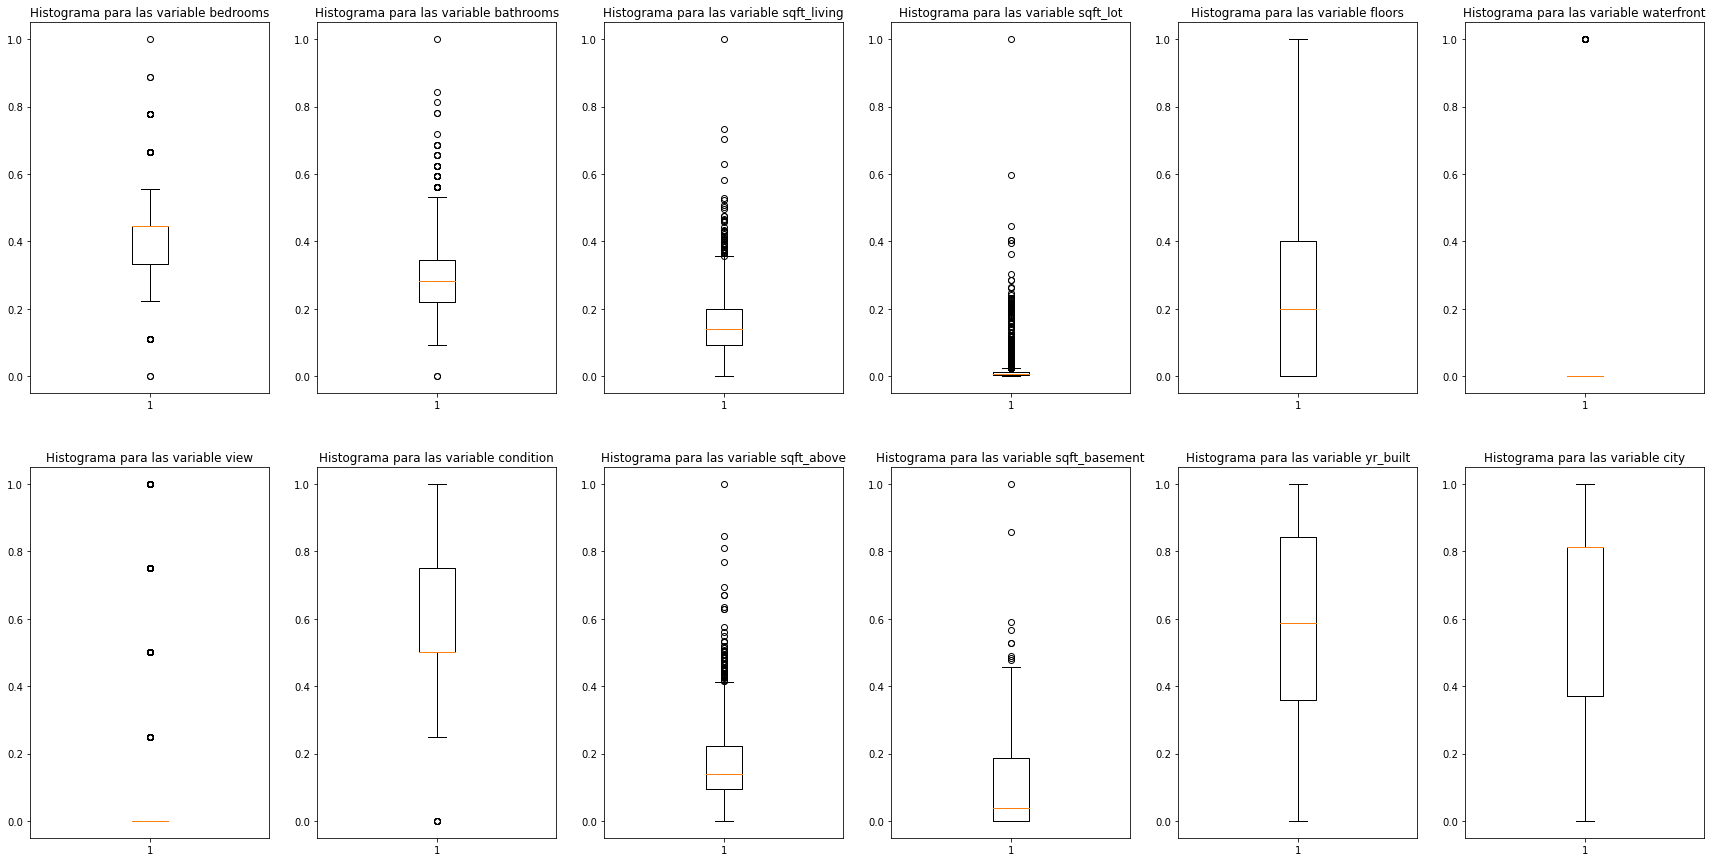

In [ ]:
variables = Data_DataFrame.columns
color = {"boxes": "Red",
"whiskers": "Orange",
"medians": "Blue",
"caps": "Gray"}

fig, axs = plt.subplots(2,6, figsize=(30,15))
indice = range(0,12,1)

for i,variable in zip(indice, variables):
    axs[int(i/6),i%6].boxplot(data_limpia[:,i])
    axs[int(i/6),i%6].set_title('Histograma para las variable ' + variable)


Podemos ver que en algunas variables si se redujo el número de datos atipicos. Por otro lado, otras variables siguen presentando datos atipicos ya que la detección de outliers se hizo de manera multivarida, es decir teniendo en cuenta el espacio de todadas las variables

# Analisis de correlación

Ahora procedemos a ver la correlación entre las variables de entrada 

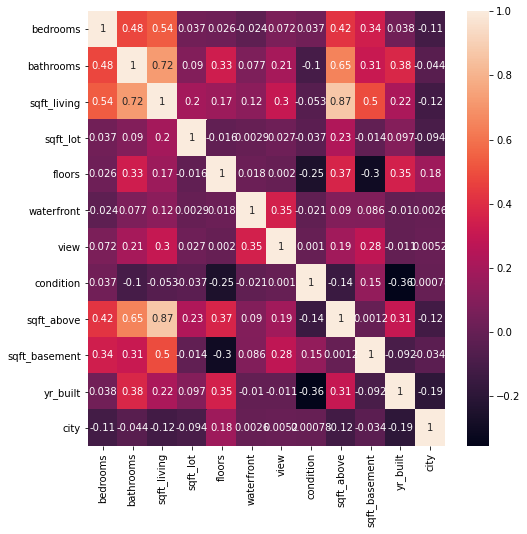

In [ ]:
names_aux = Data_DataFrame.columns
Data_DataFrame_limpia = pd.DataFrame()
Data_DataFrame_limpia[names_aux] = pd.DataFrame(data_limpia)
Input_DataFrame_limpia = Data_DataFrame_limpia.drop('price', axis =1)
Ouput_DataFrame_limpia = Data_DataFrame_limpia['price']

corr = Input_DataFrame_limpia.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr, annot=True)
plt.show()

Podemos ver que hay variables que hay varuables muy correlacionadas como el tamaño de la terraza y el tamaño de la sala, al igual que el tamaño de la terraza y el número de baños. Sin embargo esta correlación no supera 0.9 por lo que no se considera relavante para la eliminación de variables correlacionadas.

Por otro lado calculamos la correlación de la variables de salida con respecto a las variables de entrada, para ver la relación que hay entre ellas

In [ ]:
for name in Input_DataFrame_limpia.columns :
    r,p  = pearsonr(Input_DataFrame_limpia[name],Ouput_DataFrame_limpia)
    r = round(r,3)
    print(f"Correlación Pearson: r={r}")
    

Correlación Pearson: r=0.144
Correlación Pearson: r=0.277
Correlación Pearson: r=0.375
Correlación Pearson: r=0.017
Correlación Pearson: r=0.089
Correlación Pearson: r=0.126
Correlación Pearson: r=0.186
Correlación Pearson: r=0.021
Correlación Pearson: r=0.333
Correlación Pearson: r=0.173
Correlación Pearson: r=0.016
Correlación Pearson: r=0.003


Podemos ver que no hay mucha influcencia de las variables con respecto a la variable de salida, con lo que usaremos la regresión Lasso para ver la relevancia de cada una de ellas en la salida. 

Tenemos que en la regresion Lasso existe un parámetro de penalización $\alpha$, el cual afecta el desempeño del algoritmo, entonces usaremos busqueda por fuerza bruta de tal manera que podamos encontrar el parámetro óptimo usando el error cuadratico medio como función objetivo. 

Por otro lado eliminamos las variables cuyo coeficiente en la regresión Lasso sera cero

In [ ]:
parametro_optimo,variables_eliminar = Lasso(Input_DataFrame_limpia, Ouput_DataFrame_limpia)
print(parametro_optimo)
print(variables_eliminar)

1.0
[0]


Es decir que el parámetro optimo para la regresión Lasso es 1.0 y el unico coeficiente de esta regresión que esta en cero es el de la primera variable, por lo que esta es la que eliminaremos. 

In [ ]:
Input_DataFrame_limpia.drop(Input_DataFrame_limpia.columns[variables_eliminar],axis=1,inplace=True)


# Sistemas de Aprendizaje

Ahora uzamos maquinas de aprendizaje como regresores de tal manera que se reciba los datos de entrada y  se puede predecir el valor del inmueble. Para realizar el regresor partimos el conjunto de datos en entrenamiento (60%) , testo (20%) y validación (20%). 

No obstante usamos 4 algoritmos de aprendizaje en los que se encuentra: Maquina de Soporte vecotorial, Arbol de disción, Proceso gaussiano con kernel de base radial y una red neuronal. Se escogen estas cuatro maquinas para tener una variedad a nivel de complejidad; una maquina simple (arbol de desición) , una maquina no tan compleja (maquina de soporte vectorial) y maquinas con mayor complejidad (red neuronal y proceso gaussiano). Del tal manera que se pueda realizar una comparación de maquinas a nivel de complejidad y nivel de generalización

In [ ]:
X = np.array(Input_DataFrame_limpia)
y = np.array(Ouput_DataFrame_limpia)
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.40)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.50)

**Maquina de Soporte Vectorial con Kernel polinomial**

In [ ]:
#from sklearn.metrics import mean_squared_error
classifier1 =  SVR(kernel = 'poly')
classifier1.fit(X_train, y_train)
y_pred = classifier1.predict(X_val)
mse = mean_squared_error(y_pred,y_val)
print(mse)

0.003038174314062959


**Arbol de Desición**

En esta sección mostramos el diagrama del arbol para ver a nivel de data cual es la variable con mayor relevancia

0.005582169378479109


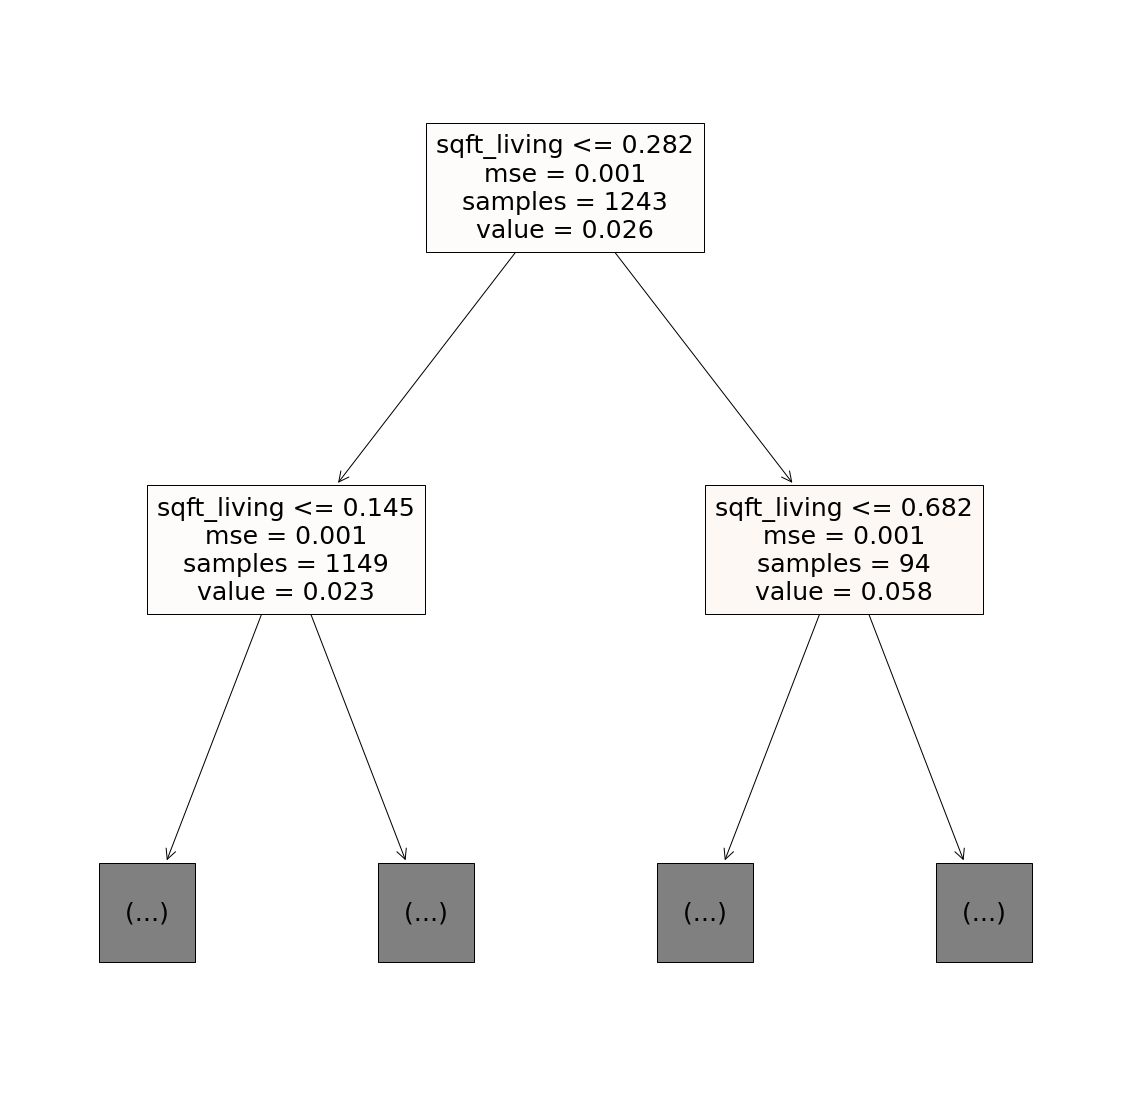

In [ ]:
classifier2 = DecisionTreeRegressor()
classifier2.fit(X_train, y_train)
y_pred = classifier2.predict(X_val)
mse = mean_squared_error(y_pred,y_val)
print(mse)

plt.figure()
plt.rcParams["figure.figsize"] = (40,40)

_ = plot_tree(classifier2, max_depth=1, feature_names=Input_DataFrame_limpia.columns, class_names= "Winner", filled=True)

Se puede ver que la variable con más relevancia en la data es el tamaño de la sala 

**Proceso Gaussiano con Kernel de Base Radial**

In [ ]:
kernel = 1.0 * RBF(1.0)
classifier3 = GaussianProcessRegressor(kernel=kernel,random_state=0)
classifier3.fit(X_train, y_train)
y_pred = classifier3.predict(X_val)
mse = mean_squared_error(y_pred,y_val)
print(mse)

0.0014632875191529773


**Red Neuronal con 100 capas y 100 neruonas por capa**

In [ ]:
classifier4 = MLPRegressor(activation = 'relu', hidden_layer_sizes =(100,100))
classifier4.fit(X_train, y_train)
y_pred = classifier4.predict(X_val)
mse = mean_squared_error(y_pred,y_val)
print(mse)

0.0007903061754659001


Ahora usamos diferentes metricas para realizar la comparación, de los algoritmo usando el conjunto de validación de tal maneras podamos escoger el mejor algoritmo para predecir el precio el inmuble. No obstante tambien mostramos el desempeño de las maquinas en el conjunto de entrenamiento de tal manera que podamos ver si es necesario una mayor complejidad en los algoritmos.


**Conjunto de entrenamiento**

In [ ]:
classifiers = [classifier1, classifier2, classifier3, classifier4]
C_list = ["C"+format(i + 1) for i in range(len(classifiers))]
classifiers_names = ['SVM', 'Decision Tree', 'Gaussian Process', 'Multilayer Perceptron']
new_index = dict(zip(C_list,classifiers_names))
performance_val = assess_performance(classifiers, X_train, y_train)
pd.DataFrame(performance_val).T.rename(index = new_index)

,mean_squared_error,max_error,mean_absolute_error,median_absolute_error,r2_score
SVM,3.138936e-03,8.668291e-01,4.431031e-02,4.287948e-02,-2.690882
Decision Tree,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
Gaussian Process,1.505183e-16,2.964503e-07,1.993839e-09,1.135249e-09,1.000000
Multilayer Perceptron,9.887515e-04,9.742748e-01,1.158791e-02,8.086358e-03,-3.529354


**Conjunto de validación**

In [ ]:
performance_val = assess_performance(classifiers, X_val, y_val)
pd.DataFrame(performance_val).T.rename(index = new_index)

,mean_squared_error,max_error,mean_absolute_error,median_absolute_error,r2_score
SVM,0.003038,0.428889,0.044544,0.040740,-2.632936
Decision Tree,0.005569,0.992478,0.016732,0.006619,-0.125058
Gaussian Process,0.001463,0.485107,0.025167,0.020684,-1922.668343
Multilayer Perceptron,0.000790,0.466255,0.012390,0.007964,-2.827514


Por otro lado promediamos en valor de las metricas usadas y esocgemos el de valor error, el cual es la maquina de soporte vectorial y este es el algorimo que escogemos como pronistacador del precio del inmueble

**Conjunto de Testeo**

Ahora validamos las metricas anteriores en el conjunto de testeo , para ver que tan bueno es el algoritmo pronosticando un conjunto de datos que no ha visto

In [ ]:
y_pred = classifier1.predict(X_test)
mse = mean_squared_error(y_pred,y_test)
maxError= max_error(y_pred,y_val)
MeanAbsolute = mean_absolute_error(y_pred,y_val)
MedianAbsolute= median_absolute_error(y_pred,y_val)
r2score= r2_score(y_pred,y_val)


print('El error cuadratico medio es: ', str(round(mse,4)))
print('El error máximo es: ', str(round(maxError,4)))
print('El error absoluto medio es: ', str(round(MeanAbsolute,4)))
print('El error mediano absoluto es: ', str(round(MedianAbsolute,4)))
print('El R2 score es:', str(round(r2score,4)))

El error cuadratico medio es:  0.0023
El error máximo es:  0.4415
El error absoluto medio es:  0.0413
El error mediano absoluto es:  0.04
El R2 score es: -2.1802


A continuación mostramos los valores predichos con la maquina de soporte vectorial y los valores reales del problema


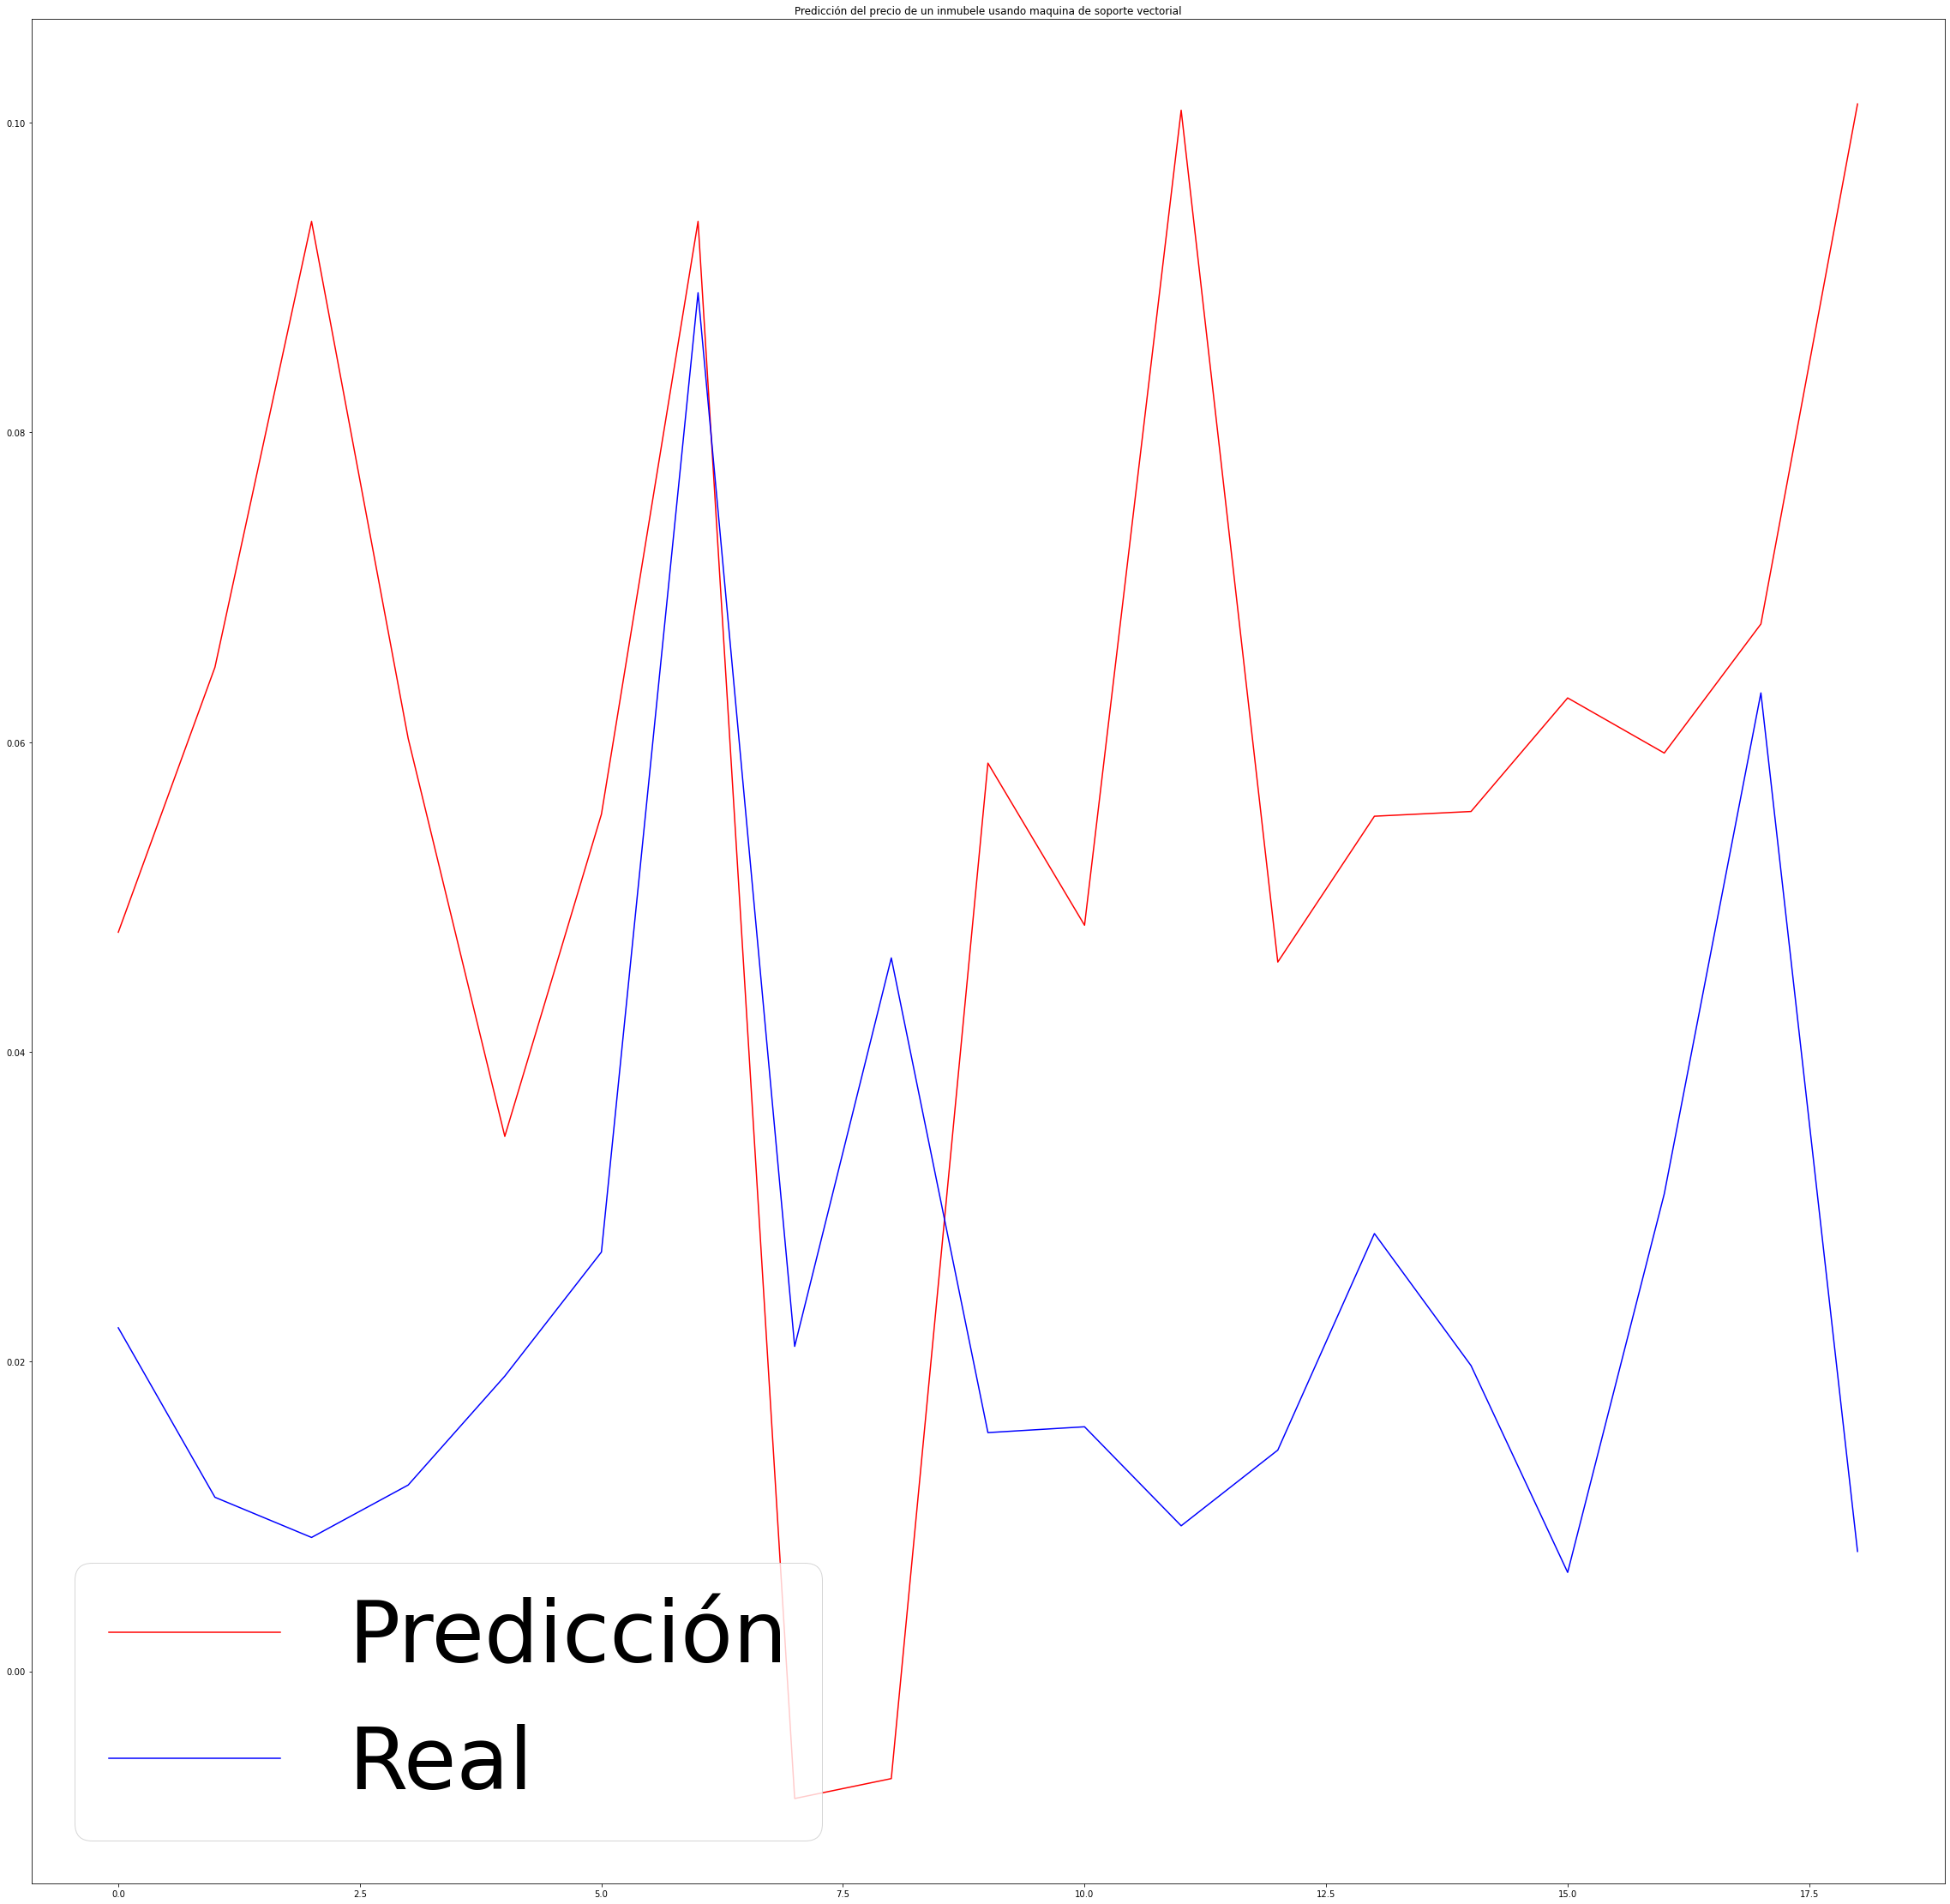

In [ ]:
plt.plot(y_pred[1:20], 'r')
plt.plot(y_test[1:20], 'b')
plt.title('Predicción del precio de un inmubele usando maquina de soporte vectorial')
plt.legend(['Predicción', 'Real'], fontsize= 100)
plt.show()

Podemos ver que el precio que se estima con la maquina es mucho mayor que el real, por lo que se tendria que ajustar de una u otra el escalamiento de la predicción que se esta realiazando. Por otro lado una buena práctica sería estimar de manera óptima los hiperparámetros de los modelos de tal manera que se pueda aumentar el nivel de generalización de cada uno de ellos.

# Concluciones

1. Cuando se esta trabajando con este tipo de modelos es importante utilizar herramientas estadisticas para el análisis de los datos de tal manera que se pueda ver sesgos , datos atipicos , variables correlacionadas o variables que no aportan información relvante al conjunto de datos, tal como es el caso de la reducción usando la regresión Lasso. De tal manera que este preprocesamiento de los datos y entendimiento de los mismos nos ayuden a tomar desiciones de tal manera que podamos aumentar la capacidad de generalización del modelo que se vayan a plantear.


2. Diferentes metricas que midan la capacidad de aprendizaje de la maquina, en el conjunto de validación, testeo y entrenamiento nos dan herramientas suficientes para ver si estamos en un problema de overfiting o underfiting , tal que apartir de estos resultados podamos tomar desiciones sobre si aplicar mayor complejidad a los modelos o reducirla. 


3. Es prefeirble tener modelos menos complejos con una capacidad de generalización buena, que tener modelos de alta complejidad con excelente capacidad de generalización  pero costos computacionalmente o dificiles de entender.